# Word-Level LSTM Models

# 0. Libraries Imports

In [0]:
train_mode = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('punkt')

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from keras.layers import Flatten, Dense, LSTM, Input, Dropout, BatchNormalization, Embedding, Lambda, dot
from keras.models import Model, Sequential

from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from gensim.models import Word2Vec, KeyedVectors

from sklearn.decomposition import PCA

from time import time

  
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity

# from nltk.corpus import stopwords

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

import re

# Google Drive mounting for reading data
from google.colab import drive
drive.mount('/content/drive/')

# Static seed for reproduction
seed = 0

dirpath = './drive/My Drive/Colab Notebooks/project_3/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# 1. Data Preprocessing

In [0]:
# Dataset is now stored in a Pandas Dataframe

prod_desc = pd.read_csv(dirpath + 'product_descriptions.csv', encoding="ISO-8859-1")

train_df = pd.read_csv(dirpath + 'train.csv', encoding="ISO-8859-1")
test_df = pd.read_csv(dirpath + 'test2.csv', encoding="ISO-8859-1")

train_df = pd.merge(train_df, prod_desc, how='left', on=['product_uid'])
test_df = pd.merge(test_df, prod_desc, how='left', on=['product_uid'])

train_df['product_title'] = train_df['product_description'].map(str) + train_df['product_title'].map(str)
# train_df['product_title'] = train_df['product_description'].map(lambda x: str(x) + ' ') + train_df['product_title'].map(str)
# train_df['product_title'] = train_df['product_title'].str[:700]

test_df['product_title'] = test_df['product_description'].map(str) + train_df['product_title'].map(str)
# test_df['product_title'] = test_df['product_description'].map(lambda x: str(x) + ' ') + train_df['product_title'].map(str)
# test_df['product_title'] = test_df['product_title'].str[:700]

In [0]:
train_df

In [0]:
def vis_pca(model):
  # fit a 2d PCA model to the vectors
  X = model[model.wv.vocab]
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  # create a scatter plot of the projection
  plt.scatter(result[:, 0], result[:, 1])
  words = list(model.wv.vocab)
  for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()

def vis_tsne(model):
  # fit a 2d PCA model to the vectors
  X = model[model.wv.vocab]
  pca = TSNE()
  result = pca.fit_transform(X)
  # create a scatter plot of the projection
  plt.scatter(result[:, 0], result[:, 1])
  words = list(model.wv.vocab)
  for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()
  
def prep_texts(df):
  df = pd.DataFrame(df)
#   df['product_title'] = df['product_title'].apply(lambda x: list(x))
#   df['search_term'] = df['search_term'].apply(lambda x: list(x))
  df['product_title'] = df['product_title'].apply(text_to_word_list)
  df['serach_term'] = df['search_term'].apply(text_to_word_list)
  df = df.rename(index=str, columns={'search_term': 'question1', 'product_title': 'question2'})
  return df

In [0]:
i = 0
newvocab = dict()
for k,v in wvmodel.wv.vocab.items():
  if (len(k)<=2):
    continue
  newvocab[k] = v
  i = i + 1;
  if (i>100):
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


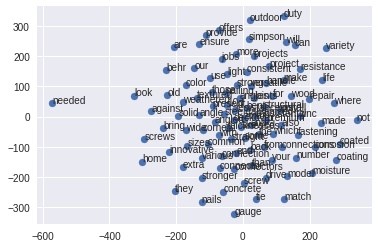

In [0]:
# fit a 2d PCA model to the vectors
  X = wvmodel[newvocab]
  pca = TSNE()
  result = pca.fit_transform(X)
  # create a scatter plot of the projection
  plt.scatter(result[:, 0], result[:, 1])
  words = list(newvocab)
  for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()

In [0]:
wvmodel.most_similar('stool')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bench', 0.6790950894355774),
 ('homesullivan', 0.6700759530067444),
 ('sofa', 0.6494880318641663),
 ('barstool', 0.626984715461731),
 ('stools', 0.6052266359329224),
 ('upholstered', 0.6011030673980713),
 ('recliner', 0.5902377963066101),
 ('ottoman', 0.5840995907783508),
 ('backless', 0.5779173970222473),
 ('pub', 0.5669509172439575)]

In [0]:
train_df.iloc[0]['product_title']

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws Simpson Strong-Tie 12-Gauge Angle'

In [0]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = nltk.word_tokenize(text)

    return text

In [0]:
nltk.word_tokenize("Hi my name is eden.")

# 2. Word2Vec

In [0]:
save_progress = False

def create_word2vec(sentences):
  if train_mode:
    # Gensim Word2Vec model
    model = Word2Vec(sentences, size=embedding_dim, window=window_size, min_count=10, seed=seed)
    model.train(sentences, total_examples=len(sentences), epochs=5)
    if save_progress:
      model.save(dirpath + 'wordlevel_word2vec.model')
    return model
  else:
    model = Word2Vec.load(dirpath + 'wordlevel_word2vec.model')
    return model

def get_sents_for_wv(df):
  biglist = list(df['question1']) + list(df['question2'])
  prep_list = []
  for sent in biglist:
    prep_list.append(list(sent))
  return prep_list

In [0]:
# word2vec.most_similar('1')

In [0]:
#FOR TRAINING PURPOSES
embedding_dim = 128
window_size = 10

train_df = prep_texts(train_df)
test_df = prep_texts(test_df)
sents = get_sents_for_wv(train_df)
wvmodel = create_word2vec(sents)

In [0]:
vis_pca(wvmodel)

In [0]:
vis_tsne(wvmodel)

In [0]:
# wvmodel.save(dirpath + 'WORD2VEC_LAST_FINAL.model')

In [0]:
# FOR PRETRAINED MODEL LOADING
embedding_dim = 128
window_size = 10

train_df = prep_texts(train_df)
test_df = prep_texts(test_df)
wvmodel = Word2Vec.load(dirpath + 'WORD2VEC_LAST_FINAL.model')

# 3. Embedding Matrix Prep

In [0]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
# word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
word2vec = wvmodel.wv

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in row[question]:

                # Check for unwanted words
                if word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
# embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

# del word2vec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
max_seq_len_q1 = max(train_df.question1.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max())

max_seq_len_q2 = int(max(train_df.question2.map(lambda x: len(x)).mean(),
                     test_df.question2.map(lambda x: len(x)).mean()))

max_seq_lens = {
    'left': max_seq_len_q1,
    'right': max_seq_len_q2
}

# Split to train validation
validation_size = int(len(train_df) * 0.2)
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
X['question2'] = X['question2'].apply(lambda x: x[:max_seq_len_q2])
Y = train_df['relevance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = test_df['relevance']

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_lens[side])

# Make sure everything is ok
# assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)
print('Max seq length of q1 (search_term): {}\n\nMax seq length of q2 (product): {}'.format(max_seq_len_q1, max_seq_len_q2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Max seq length of q1 (search_term): 60

Max seq length of q2 (product): 202


# 4. Siamese Network

In [0]:
def print_error_analysis(preds, y_true, title='Test'):
  test_mse = mean_squared_error(y_true, preds)
  test_rmse = np.sqrt(test_mse)
  print(title + ' RMSE: {}'.format(test_rmse))
  test_mae = mean_absolute_error(y_true, preds)
  print(title + ' MAE: {}'.format(test_mae))
  
def print_results(preds, y):
  fig = plt.figure()
  plt.plot(preds[:50], '-')
  plt.plot(y[:50], '--')
  plt.show()

In [0]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 5

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_lens['left'],), dtype='int32')
right_input = Input(shape=(max_seq_lens['right'],), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=None, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# # Calculates the distance as defined by the MaLSTM model
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output]) # Exp Negative Manhattan
malstm_distance = dot(inputs = [left_output, right_output], axes = -1, normalize = True) # Cosine Similarity

normalize_output = Lambda(lambda x: (x * 2 + 1))(malstm_distance)


# Pack it all up into a model
malstm = Model([left_input, right_input], [normalize_output])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 206s 3ms/step - loss: 0.3165 - mean_absolute_error: 0.4576 - val_loss: 0.2854 - val_mean_absolute_error: 0.4393
Epoch 2/5
59253/59253 [==============================] - 204s 3ms/step - loss: 0.2724 - mean_absolute_error: 0.4287 - val_loss: 0.2808 - val_mean_absolute_error: 0.4333
Epoch 3/5
59253/59253 [==============================] - 204s 3ms/step - loss: 0.2610 - mean_absolute_error: 0.4197 - val_loss: 0.2753 - val_mean_absolute_error: 0.4276
Epoch 4/5
59253/59253 [==============================] - 204s 3ms/step - loss: 0.2514 - mean_absolute_error: 0.4117 - val_loss: 0.2753 - val_mean_absolute_error: 0.4337
Epoch 5/5
59253/59253 [==============================] - 204s 3ms/step - loss: 0.2438 - mean_absolute_error: 0.4053 - val_loss: 0.2703 - val_mean_absolute_error: 0.4285
Training time finished.
5 epochs in 0:17:04.037921


In [0]:
malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=1,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

Train on 59253 samples, validate on 14814 samples
Epoch 1/2
59253/59253 [==============================] - 218s 4ms/step - loss: 0.2514 - mean_absolute_error: 0.4112 - val_loss: 0.2646 - val_mean_absolute_error: 0.4192
Epoch 2/2
59253/59253 [==============================] - 218s 4ms/step - loss: 0.2447 - mean_absolute_error: 0.4054 - val_loss: 0.2612 - val_mean_absolute_error: 0.4198


In [0]:
# malstm.save(dirpath + 'model_8_1__15_17.h5')

In [0]:
preds = malstm.predict([X_test['left'], X_test['right']])

In [0]:
y_test = test_df.relevance
print_error_analysis(preds, y_test)
print_results(preds, y_test)

In [0]:
malstm.save(dirpath + 'WORD_MODEL_LAST.h5')

# 5. Load pre-trained model

In [0]:
malstm = load_model(dirpath + 'WORD_MODEL_LAST.h5')

In [0]:
preds1 = malstm.predict([X_test['left'], X_test['right']])
preds2 = malstm.predict([X_train['left'], X_train['right']])

In [0]:
print_error_analysis(preds1, y_test)
print_results(preds1, y_test)

In [0]:
print_error_analysis(preds2, Y_train)
print_results(preds2, Y_train)

# 6. Feature Extraction

In [0]:
def get_feature_extractor_model(trained_model=None):
  if not trained_model:
    trained_model = load_model(dirpath + 'WORD_MODEL_LAST.h5')
  features_layer = trained_model.layers[-2].input
  feat_model = Model(inputs=trained_model.input, outputs=features_layer)
  return feat_model

In [0]:
feat_model = get_feature_extractor_model(malstm)
feat_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 202)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             3394944     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           35800       embedding_1[0][0]                
          

In [0]:
preds = feat_model.predict([X_train['left'], X_train['right']])

preds1 = np.array(preds[0])
preds2 = np.array(preds[1])

train_features = np.concatenate((preds1, preds2), axis=1)

In [0]:
preds_test = feat_model.predict([X_test['left'], X_test['right']])

preds1 = np.array(preds_test[0])
preds2 = np.array(preds_test[1])

test_features = np.concatenate((preds1, preds2), axis=1)

In [0]:
preds_val = feat_model.predict([X_validation['left'], X_validation['right']])

preds1 = np.array(preds_val[0])
preds2 = np.array(preds_val[1])

val_features = np.concatenate((preds1, preds2), axis=1)

In [0]:
from xgboost.sklearn import XGBRegressor

def fe_xgboost():
  training_start_time = time()
  xgb_model = XGBRegressor(n_estimators=16, learning_rate=0.1,
                       gamma=0, subsample=0.8, colsample_bytree=1, max_depth=16)
  xgb_model.fit(train_features, Y_train)
  print("Training time finished: {}\n".format(datetime.timedelta(seconds=time()-training_start_time)))
  preds_train = xgb_model.predict(train_features)
  preds_test = xgb_model.predict(test_features)
  preds_val = xgb_model.predict(val_features)
  return preds_train, preds_test, preds_val

# def fe_svr():
#   svc_model = SVR(gamma='scale', C=1.0)
#   svc_model.fit(train_features, Y_train)
#   preds_train = svc_model.predict(train_features)
#   preds_test = svc_model.predict(test_features)
#   preds_val = svc_model.predict(val_features)
#   return preds_train, preds_test, preds_val

def fe_rfr():
  training_start_time = time()
  svc_model = RandomForestRegressor(max_depth=2, random_state=seed, n_estimators=192)
  svc_model.fit(train_features, Y_train)
  print("Training time finished: {}\n".format(datetime.timedelta(seconds=time()-training_start_time)))
  preds_train = svc_model.predict(train_features)
  preds_test = svc_model.predict(test_features)
  preds_val = svc_model.predict(val_features)
  return preds_train, preds_test, preds_val

In [0]:
training_start_time = time()

fe_preds_train, fe_preds_test, fe_preds_val = fe_xgboost()

print("Training time finished: {}\n".format(datetime.timedelta(seconds=time()-training_start_time)))

print('Minimum preds train: {}\nMaximum preds train: {}'.format(fe_preds_train.min(), fe_preds_train.max()))
print('Minimum preds test: {}\nMaximum preds test: {}'.format(fe_preds_test.min(), fe_preds_test.max()))
print('Minimum preds validation: {}\nMaximum preds validation: {}'.format(fe_preds_val.min(), fe_preds_val.max()))

#Fix out of range predictions
fe_preds_train[fe_preds_train<1] = 1
fe_preds_test[fe_preds_test<1] = 1
fe_preds_val[fe_preds_val<1] = 1

print_error_analysis(fe_preds_train, Y_train, 'Train')
print_error_analysis(fe_preds_val, Y_validation, 'Validation')
print_error_analysis(fe_preds_test, Y_test, 'Test')

Training time finished: 0:00:27.735354

Training time finished: 0:00:28.716543

Minimum preds train: 0.8691517114639282
Maximum preds train: 2.4418373107910156
Minimum preds test: 1.0073843002319336
Maximum preds test: 2.382542133331299
Minimum preds validation: 0.955460786819458
Maximum preds validation: 2.4065709114074707
Train RMSE: 0.5162644156477525
Train MAE: 0.43237481842358405
Validation RMSE: 0.6155048821827286
Validation MAE: 0.5260890213680667
Test RMSE: 0.671742581106928
Test MAE: 0.5756632738981748


In [0]:


fe_preds_train, fe_preds_test, fe_preds_val = fe_rfr()



print('Minimum preds train: {}\nMaximum preds train: {}'.format(fe_preds_train.min(), fe_preds_train.max()))
print('Minimum preds test: {}\nMaximum preds test: {}'.format(fe_preds_test.min(), fe_preds_test.max()))
print('Minimum preds validation: {}\nMaximum preds validation: {}'.format(fe_preds_val.min(), fe_preds_val.max()))

#Fix out of range predictions
fe_preds_train[fe_preds_train<1] = 1
fe_preds_test[fe_preds_test<1] = 1
fe_preds_val[fe_preds_val<1] = 1

print_error_analysis(fe_preds_train, Y_train, 'Train')
print_error_analysis(fe_preds_val, Y_validation, 'Validation')
print_error_analysis(fe_preds_test, Y_test, 'Test')

Training time finished: 0:02:57.857803

Minimum preds train: 2.007914653065507
Maximum preds train: 2.4298300347126496
Minimum preds test: 2.007914653065507
Maximum preds test: 2.4298300347126496
Minimum preds validation: 2.0095918351523516
Maximum preds validation: 2.4298300347126496
Train RMSE: 0.5291250464023634
Train MAE: 0.43335822211081404
Validation RMSE: 0.5326810155494316
Validation MAE: 0.4379692741003557
Test RMSE: 0.5323707328359302
Test MAE: 0.4361651097691325
